## Import statements

In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from IPython.display import display

## Useful functions

In [10]:
def normalize_datetime(df, colname):
    df = df.rename(columns={colname: 'datetime'})
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
    return df

In [14]:
def calculate_dk_area(row, area_column, area_type):
    try:
        if area_type == "area":
            return str(row[area_column])[6]
        elif area_type == "municipality":
            return "1" if int(row[area_column]) >= 500 else "2"
        elif area_type == "longitude":
            val = row[area_column]
            if pd.isnull(val):
                return None
            try:
                val = float(val)
                return "1" if val < 11 else "2"
            except ValueError:
                return None
    except Exception:
        return None

## Data preparation

### 1. Day ahead prices

In [16]:
# day_ahead = pd.read_csv('DayAheadPrices/DayAheadPrices_DK1_202401010000-202501010000.csv')
day_ahead1 = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/DayAheadPrices/DayAheadPrices_DK1_202401010000-202501010000.csv')
day_ahead2 = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/DayAheadPrices/DayAheadPrices_DK2_202401010000-202501010000.csv')
day_ahead = pd.concat([day_ahead1, day_ahead2], ignore_index=True)

day_ahead['MTU (UTC)'] = day_ahead['MTU (UTC)'].str.split(' - ').str[1]
day_ahead['MTU (UTC)'] = pd.to_datetime(day_ahead['MTU (UTC)'], format='%d/%m/%Y %H:%M:%S', utc=True)
day_ahead["CalculatedDKArea"] = day_ahead.apply(lambda row: calculate_dk_area(row, "Area", "area"), axis=1)

display(day_ahead)

,MTU (UTC),Area,Sequence,Day-ahead Price (EUR/MWh),Intraday Period (UTC),Intraday Price (EUR/MWh),CalculatedDKArea
0,2024-01-01 00:00:00+00:00,BZN|DK1,Without Sequence,16.99,NaN,NaN,1
1,2024-01-01 01:00:00+00:00,BZN|DK1,Without Sequence,28.14,NaN,NaN,1
2,2024-01-01 02:00:00+00:00,BZN|DK1,Without Sequence,26.66,NaN,NaN,1
3,2024-01-01 03:00:00+00:00,BZN|DK1,Without Sequence,4.14,NaN,NaN,1
4,2024-01-01 04:00:00+00:00,BZN|DK1,Without Sequence,-0.03,NaN,NaN,1
...,...,...,...,...,...,...,...
17563,2024-12-31 19:00:00+00:00,BZN|DK2,Without Sequence,24.24,NaN,NaN,2
17564,2024-12-31 20:00:00+00:00,BZN|DK2,Without Sequence,22.59,NaN,NaN,2
17565,2024-12-31 21:00:00+00:00,BZN|DK2,Without Sequence,15.70,NaN,NaN,2
17566,2024-12-31 22:00:00+00:00,BZN|DK2,Without Sequence,7.98,NaN,NaN,2


### 2. Consumption

In [21]:
with zipfile.ZipFile('2024_Consumption.zip') as z:
    # Get the first (and only) file inside the zip
    file_name = z.namelist()[0]

    # Open the file inside the zip and read it with pandas
    with z.open(file_name) as f:
        consumption = pd.read_csv(f)

#with open('region_muncipality.json') as f:
#    region_to_dk = json.load(f)

#consumption['Area'] = consumption['RegionName'].map(region_to_dk)
consumption['TimeUTC'] = pd.to_datetime(consumption['TimeUTC'], format='%Y-%m-%dT%H:%M:%S')
consumption['TimeUTC'] = consumption['TimeUTC'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
'''consumption_area = (
    consumption.groupby(["TimeUTC", "Area"])["ConsumptionkWh"]
    .sum()
    .reset_index()
)'''
consumption["CalculatedDKArea"] = consumption.apply(lambda row: calculate_dk_area(row, "MunicipalityCode", "municipality"), axis=1)

display(consumption)

,TimeUTC,TimeDK,MunicipalityCode,Municipality,RegionName,HousingCategory,HeatingCategory,ConsumptionkWh,CalculatedDKArea
0,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Parcel- og rækkehuse,Elvarme eller varmepumpe,5053.475,1
1,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Parcel- og rækkehuse,Andet,7957.491,1
2,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Fritidshuse,Elvarme eller varmepumpe,3813.127,1
3,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Fritidshuse,Andet,218.168,1
4,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Etageejendom,Elvarme eller varmepumpe,89.426,1
...,...,...,...,...,...,...,...,...,...
5699726,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Fritidshuse,Andet,178.665,2
5699727,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Etageejendom,Elvarme eller varmepumpe,514.990,2
5699728,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Etageejendom,Andet,42063.577,2
5699729,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Andet,Elvarme eller varmepumpe,30.190,2


### 3. Sunlight

In [22]:
#sunlight = pd.read_csv('weather/all_danish_hourly_sunlight_2024 formatted.csv', delimiter=';')
sunlight = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/weather/all_danish_hourly_sunlight_2024%20formatted.csv', delimiter=';')

sunlight['datetime'] = pd.to_datetime(
    sunlight['date'] + ' ' + sunlight['to_time'],
    format='%Y-%m-%d %H:%M'  # matches your input
)

# Force timezone UTC
sunlight['datetime'] = sunlight['datetime'].dt.tz_localize('UTC')

# Convert to ISO 8601 with Z suffix
sunlight['datetime'] = sunlight['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

sunlight["CalculatedDKArea"] = sunlight.apply(lambda row: calculate_dk_area(row, "longitude", "longitude"), axis=1)

display(sunlight)

,date,station_id,station_name,to_time,sunshine_minutes,latitude,longitude,datetime,CalculatedDKArea
0,2024-01-04,6141,Abed,16:00,4.5,54.8275,11.3292,2024-01-04T16:00:00Z,2
1,2024-01-05,6141,Abed,10:00,2.0,54.8275,11.3292,2024-01-05T10:00:00Z,2
2,2024-01-05,6141,Abed,11:00,27.0,54.8275,11.3292,2024-01-05T11:00:00Z,2
3,2024-01-05,6141,Abed,12:00,19.0,54.8275,11.3292,2024-01-05T12:00:00Z,2
4,2024-01-05,6141,Abed,13:00,29.0,54.8275,11.3292,2024-01-05T13:00:00Z,2
...,...,...,...,...,...,...,...,...,...
86153,2024-12-22,6136,Tystofte,16:00,11.5,55.2465,11.3285,2024-12-22T16:00:00Z,2
86154,2024-12-24,6136,Tystofte,10:00,22.0,55.2465,11.3285,2024-12-24T10:00:00Z,2
86155,2024-12-24,6136,Tystofte,11:00,22.5,55.2465,11.3285,2024-12-24T11:00:00Z,2
86156,2024-12-24,6136,Tystofte,14:00,33.0,55.2465,11.3285,2024-12-24T14:00:00Z,2


### 4. Wind

In [23]:
#wind = pd.read_csv('weather/danish_hourly_wind_data_2024.csv', delimiter=';')
wind = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/weather/danish_hourly_wind_data_2024.csv', delimiter=';')

wind['datetime'] = pd.to_datetime(
    wind['date'] + ' ' + wind['to_time'],
    format='%Y-%m-%d %H:%M'  # matches your input
)

# Force timezone UTC
wind['datetime'] = wind['datetime'].dt.tz_localize('UTC')

# Convert to ISO 8601 with Z suffix
wind['datetime'] = wind['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

wind["CalculatedDKArea"] = wind.apply(lambda row: calculate_dk_area(row, "longitude", "longitude"), axis=1)

display(wind)

,date,hour,from_time,to_time,station_id,station_name,parameter,value,latitude,longitude,datetime,CalculatedDKArea
0,2024-01-01,1,01:00,02:00,6019,Silstrup,max_wind_speed_10min,6.1,56.9300,8.6412,2024-01-01T02:00:00Z,1
1,2024-01-01,1,01:00,02:00,6019,Silstrup,max_wind_speed_3sec,8.1,56.9300,8.6412,2024-01-01T02:00:00Z,1
2,2024-01-01,1,01:00,02:00,6019,Silstrup,mean_wind_speed,5.5,56.9300,8.6412,2024-01-01T02:00:00Z,1
3,2024-01-01,2,02:00,03:00,6019,Silstrup,max_wind_speed_10min,5.3,56.9300,8.6412,2024-01-01T03:00:00Z,1
4,2024-01-01,2,02:00,03:00,6019,Silstrup,max_wind_speed_3sec,6.9,56.9300,8.6412,2024-01-01T03:00:00Z,1
...,...,...,...,...,...,...,...,...,...,...,...,...
688603,2025-01-01,0,00:00,01:00,6193,Hammer Odde Fyr,max_wind_speed_3sec,24.0,55.2979,14.7718,2025-01-01T01:00:00Z,2
688604,2025-01-01,0,00:00,01:00,6193,Hammer Odde Fyr,mean_wind_speed,16.2,55.2979,14.7718,2025-01-01T01:00:00Z,2
688605,2025-01-01,0,00:00,01:00,6197,Nexø Vest,max_wind_speed_10min,12.7,55.0557,15.0953,2025-01-01T01:00:00Z,2
688606,2025-01-01,0,00:00,01:00,6197,Nexø Vest,max_wind_speed_3sec,18.9,55.0557,15.0953,2025-01-01T01:00:00Z,2


## Data Analysis

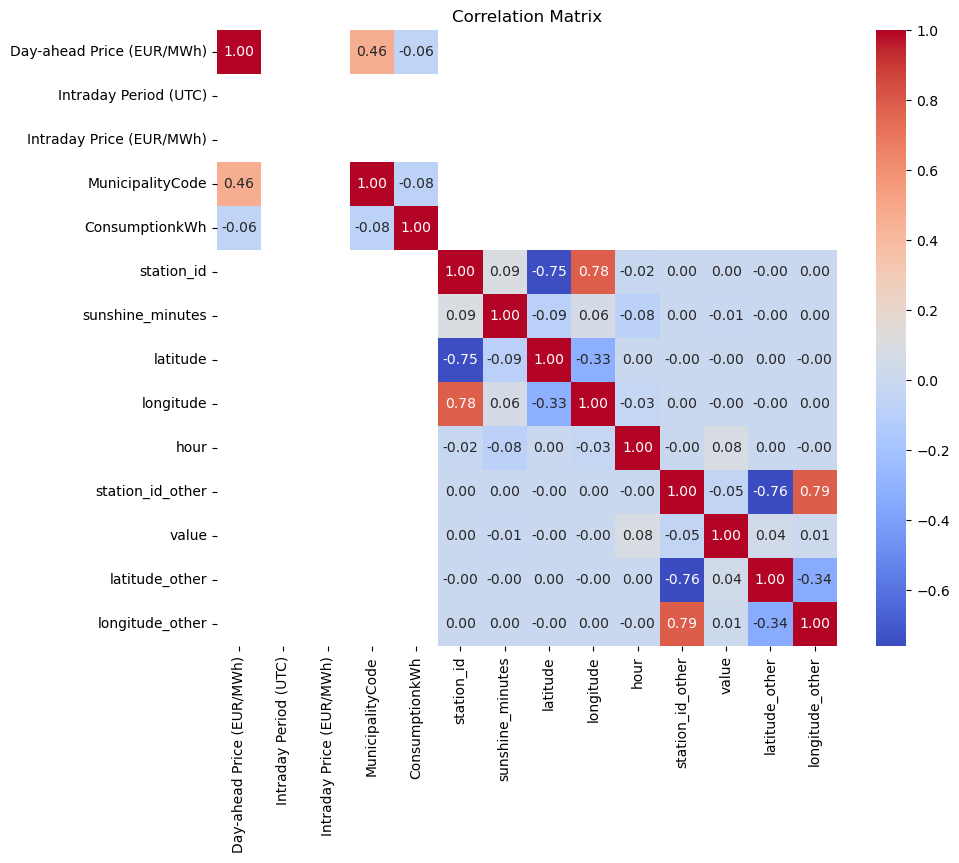

In [25]:
day_ahead = normalize_datetime(day_ahead, 'MTU (UTC)')
consumption = normalize_datetime(consumption, 'TimeUTC')

dfs = [day_ahead, consumption, sunlight, wind]

merged = dfs[0].set_index('datetime')
for dataframe in dfs[1:]:
    merged = merged.join(dataframe.set_index('datetime'), how='outer', rsuffix='_other')

merged.index = pd.to_datetime(merged.index, utc=True)


# Fill missing data if needed (forward fill is common for time series)
merged = merged.ffill()

# Calculate correlation matrix
correlation_matrix = merged.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()